In [104]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import Figure_H2H_Regret

from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

### Main functions

## Parameters

In [105]:
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"
iteration_all = np.arange(0,100)

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))

In [106]:
middle_path = '/Data_JOC_R1/Shortest_Path/Baseline_' + data_generation_process +"/"
Result_dir = project_directory + middle_path + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

#### Calibrate $\mu$ and $\lambda$

In [107]:
mu_cali_all = np.round(np.arange(0.6,0.9,0.05),4)
lamb_cali_all = np.round(np.arange(0.0,12.0,0.1),4)
iteration_all = [84]
grid = (3,3)
from Network import network_design
Network = network_design()
arcs,arc_index_mapping = Network._getArcs(grid)

L_N = grid[0]
d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
num_nodes = L_N*L_N

DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
print("DataPath:", DataPath)

x_test_cali_all,c_test_cali_all,x_train_cali_all,c_train_cali_all,noise_train_cali_all,noise_test_cali_all,W_star_cali_all = Data_LSM.load_input_data(DataPath)

cost_Oracle_Post_cali,cost_Oracle_Ante_cali = Oracle_Proc.Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_cali_all,x_test_cali_all,noise_test_cali_all,\
                                                                    iteration_all,num_feat,data_generation_process)

cost_OLS_Post_cali,cost_OLS_Ante_cali = OLS_Proc.Implement_OLS(arcs, grid,mis,bump,\
                                                    W_star_cali_all,x_test_cali_all,noise_test_cali_all,x_train_cali_all,c_train_cali_all,\
                                                    iteration_all,num_feat,data_generation_process)

cost_DDR_Post_cali,cost_DDR_Ante_cali = DDR_Proc.Implement_DDR(mu_cali_all,lamb_cali_all,arcs, grid,mis,bump,\
                                                            W_star_cali_all,x_test_cali_all,noise_test_cali_all,x_train_cali_all,c_train_cali_all,\
                                                                iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/


In [108]:
regret_mat = np.zeros((len(mu_cali_all),len(lamb_cali_all)))
h2h_mat = np.zeros((len(mu_cali_all),len(lamb_cali_all)))
mu_index = 0
for mu in mu_cali_all:
    lamb_index = 0
    for lamb in lamb_cali_all:
        h2h_mat[mu_index,lamb_index],regret_mat[mu_index,lamb_index] \
            = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                cost_DDR_Ante_cali,cost_OLS_Ante_cali,cost_Oracle_Ante_cali)
        lamb_index += 1
    mu_index += 1
regret_fix = pd.DataFrame(np.round(regret_mat*100))
regret_fix.index = mu_cali_all
regret_fix.columns = lamb_cali_all

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_71502/2767255443.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2h_mat[mu_index,lamb_index],regret_mat[mu_index,lamb_index] \


In [109]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt

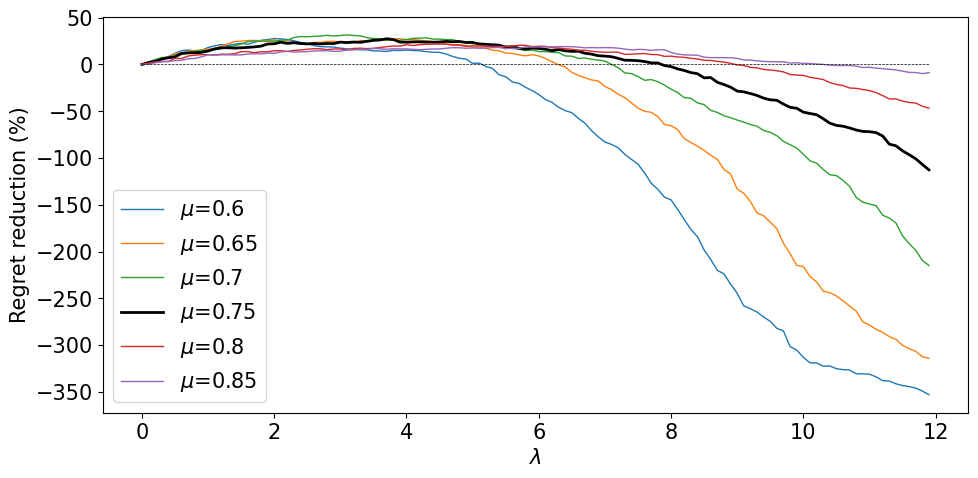

In [112]:
plt.figure(figsize=(10,5))
mu_index = 0
for mu in mu_cali_all:
    if mu_index <= 5:
        if mu_cali_all[mu_index] == 0.75:
            plt.plot(lamb_cali_all[0:120], regret_mat[mu_index,0:120]*100,color = "k",label = '$\mu$='+ str(np.round(mu, decimals = 3)), linewidth=2.0)
        else:
            plt.plot(lamb_cali_all[0:120], regret_mat[mu_index,0:120]*100,label = '$\mu$='+ str(np.round(mu, decimals = 3)), linewidth=1.0)
        # plt.text(lamb_cali_all, pio[mu][len(lamb_range_cut)-1], '$\mu$='+ str(np.round(mu, decimals = 3)))
    mu_index += 1
# plt.plot(lamb_range_cut, pio[mu_range[5]], linewidth=2.5, color = 'black')
plt.hlines(0, xmin=0,xmax=lamb_cali_all[-1],color='black', linewidth=0.5, linestyle='--')
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Regret reduction (%)', fontsize=15)

plt.rcParams.update({'font.size': 15})
plt.legend()
####### Bring the marginals closer to the scatter plot and save eps file
plt.tight_layout(pad = 1)
# plt.savefig(Result_Path_Section + '421baseline_calibration_pio.eps', format='eps')
plt.savefig(Result_dir + 'Calibration_mu_lambda.pdf', format='pdf')